# Symmetric Eigenvalue Decomposition - Algorithms for Tridiagonal Matrices


Due to their importance, there is plethora of excellent algorithms for symmetric tridiagonal matrices.

For more details, see 
[I. Slapničar, Symmetric Matrix Eigenvalue Techniques][Hog14] and the references therein.

[Hog14]: #1 "L. Hogben, ed., 'Handbook of Linear Algebra', pp. 55.1-55.25, CRC Press, Boca Raton, 2014."


__Prerequisites__

The reader should be familiar with concepts of eigenvalues and eigenvectors, related perturbation theory, and algorithms. 

__Competences__

The reader should be able to apply adequate algorithm to a given symmetric tridiagonal matrix and to assess the speed of the algorithm and the accuracy of the solution.

## Bisection and inverse iteration

The bisection method is convenient if only part of the spectrum is needed.
If the eigenvectors are needed, as well, they can be efficiently computed by
the inverse iteration method. 

### Facts

$A$ is a real symmetric $n\times n$ matrix and $T$ is a real symmetric
tridiagonal $n\times n$ matrix.
  
1. __Application of Sylvester's Theorem.__ 
Let $\alpha,\beta\in\mathbb{R}$ with $\alpha<\beta$. The number of
  eigenvalues of $A$ in the interval $[\alpha,\beta)$ is equal to $\nu
  (A- \beta I)-\nu(A-\alpha I)$. By systematically choosing the intervals $[\alpha,\beta)$, the
  bisection method pinpoints each eigenvalue of $A$ to any desired accuracy.

2. The factorization $T-\mu I=LDL^T$, where $D=\mathop{\mathrm{diag}}(d_1,\dots,d_n)$
  and $L$ is the unit lower bidiagonal matrix, is computed as:
\begin{align*}
& d_{1}=T_{11}-\mu, \quad    d_{i}=(T_{ii}-\mu)-
\frac{T_{i,i-1}^2}{d_{i-1}}, \quad i=2,\ldots n, \\
& L_{i+1,i}=\frac{T_{i+1,i}}{d_{i}}, \quad i=1,\ldots,n-1.
\end{align*}
Since the matrices $T$ and $D$ have the same inertia, this recursion
enables an efficient implementation of the bisection method for $T$.

3. The factorization from Fact 2 is essentially Gaussian elimination without
  pivoting. Nevertheless, if $d_i\neq 0$ for all $i$,
  the above recursion is very stable.
  Even when $d_{i-1}=0$ for some $i$, if the IEEE arithmetic is used, the
  computation will continue and the inertia will be computed
  correctly. Namely, in that case, we would have $d_i=-\infty$, $L_{i+1,i}=0$, 
  and $d_{i+1}=T_{i+1.i+1}-\mu$.

4. Computing one eigenvalue of $T$ by using the recursion from Fact 2 and bisection
  requires $O(n)$ operations. The corresponding eigenvector is computed
by inverse iteration. The convergence is very
fast, so the cost of computing each eigenvector is also $O(n)$
operations. Therefore, the overall cost for computing all eigenvalues and
eigenvectors is $O(n^2)$ operations.  

5. Both, bisection and inverse iteration are highly
parallel since each eigenvalue and eigenvector can be computed independently.  

6. If some of the eigenvalues are too close, the corresponding eigenvectors
  computed by inverse iteration may not be sufficiently orthogonal. In this
  case, it is necessary to orthogonalize these eigenvectors  (for example, by the
  modified Gram--Schmidt procedure). If the number of close eigenvalues is too
  large, the overall operation count can increase to $O(n^3)$.

7. The EVD computed by bisection and inverse iteration satisfies
  the error bounds from previous notebook.
  
8. The bisection method for tridiagonal matrices is implemented in the 
LAPACK subroutine [DSTEBZ](http://www.netlib.org/lapack/explore-html/d4/d48/dstebz_8f.html). This routine can compute all eigenvalues
in a given interval or the eigenvalues from $\lambda_l$ to $\lambda_k$, where $l<k$,
and the eigenvalues are ordered from smallest to largest.
Inverse iteration (with reorthogonalization) is implemented in the LAPACK
subroutine DSTEIN. 

In [22]:
import Random
Random.seed!(423)
using LinearAlgebra
n=6
T=SymTridiagonal(rand(n),rand(n-1))

6×6 SymTridiagonal{Float64,Array{Float64,1}}:
 0.200549  0.634245   ⋅         ⋅         ⋅         ⋅ 
 0.634245  0.513108  0.928204   ⋅         ⋅         ⋅ 
  ⋅        0.928204  0.340006  0.631759   ⋅         ⋅ 
  ⋅         ⋅        0.631759  0.918155  0.835154   ⋅ 
  ⋅         ⋅         ⋅        0.835154  0.566228  0.574579
  ⋅         ⋅         ⋅         ⋅        0.574579  0.30003

In [23]:
λ,U=eigen(T)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
6-element Array{Float64,1}:
 -0.8633311493125129
 -0.39326717788820553
  0.14127563439430557
  0.5996059164724927
  1.4026318491877152
  1.9511609543652702
vectors:
6×6 Array{Float64,2}:
 -0.34026   -0.327296    0.714614    0.373527   0.332886  0.126853
  0.570751   0.306433   -0.0667846   0.235017   0.630916  0.350133
 -0.613869  -0.0755841  -0.461545   -0.233332   0.377163  0.455777
  0.330692  -0.362494    0.243309   -0.441175  -0.292574  0.647925
 -0.241041   0.626391    0.122808    0.344781  -0.455031  0.456645
  0.119049  -0.51913    -0.444479    0.66128   -0.237122  0.158908

In [24]:
# Fact 2
function myLDLt(T::SymTridiagonal{S},μ::S) where S<:Real
    n=length(T.dv)
    D=Diagonal(Vector{S}(undef,n))
    L=Bidiagonal(fill(one(S),n),Vector{S}(undef,n-1),'L')
    D.diag[1]=T.dv[1]-μ
    for i=2:n
        D.diag[i]=(T.dv[i]-μ)-T.ev[i-1]^2/D.diag[i-1]
    end
    for i=1:n-1
        L.ev[i]=T.ev[i]/D.diag[i]
    end
    return D,L
end

myLDLt (generic function with 1 method)

In [25]:
σ=1.0

1.0

In [26]:
D,L=myLDLt(T,σ)

([-0.7994506998193895 0.0 … 0.0 0.0; 0.0 0.016287961586772703 … 0.0 0.0; … ; 0.0 0.0 … 8.941892388859106 0.0; 0.0 0.0 … 0.0 -0.7368907929117398], 6×6 Bidiagonal{Float64,Array{Float64,1}}:
 diag: 1.0  1.0  1.0  1.0  1.0  1.0
 sub: -0.7933515258548643  56.98712238683155  …  0.0642569529765287)

In [28]:
L

6×6 Bidiagonal{Float64,Array{Float64,1}}:
  1.0         ⋅        ⋅            ⋅       ⋅         ⋅ 
 -0.793352   1.0       ⋅            ⋅       ⋅         ⋅ 
   ⋅        56.9871   1.0           ⋅       ⋅         ⋅ 
   ⋅          ⋅      -0.0117963    1.0      ⋅         ⋅ 
   ⋅          ⋅        ⋅         -11.2263  1.0        ⋅ 
   ⋅          ⋅        ⋅            ⋅      0.064257  1.0

In [29]:
Matrix(L*D*transpose(L))-(T-σ*I)

6×6 Array{Float64,2}:
 0.0   0.0          0.0          0.0  0.0          0.0
 0.0  -1.11022e-16  0.0          0.0  0.0          0.0
 0.0   0.0          2.66454e-15  0.0  0.0          0.0
 0.0   0.0          0.0          0.0  0.0          0.0
 0.0   0.0          0.0          0.0  4.44089e-16  0.0
 0.0   0.0          0.0          0.0  0.0          0.0

In [30]:
# Inertias are the same
[λ.-σ D.diag]

6×2 Array{Float64,2}:
 -1.86333    -0.799451
 -1.39327     0.016288
 -0.858724  -53.5557
 -0.400394   -0.0743929
  0.402632    8.94189
  0.951161   -0.736891

In [31]:
# Fact 8
methods(LAPACK.stebz!)

# 2 methods for generic function "stebz!":
[1] stebz!(range::AbstractChar, order::AbstractChar, vl::Float64, vu::Float64, il::Integer, iu::Integer, abstol::Real, dv::AbstractArray{Float64,1}, ev::AbstractArray{Float64,1}) in LinearAlgebra.LAPACK at C:\Users\Ivan_Slapnicar\AppData\Local\Programs\Julia\Julia-1.4.0\share\julia\stdlib\v1.4\LinearAlgebra\src\lapack.jl:3775
[2] stebz!(range::AbstractChar, order::AbstractChar, vl::Float32, vu::Float32, il::Integer, iu::Integer, abstol::Real, dv::AbstractArray{Float32,1}, ev::AbstractArray{Float32,1}) in LinearAlgebra.LAPACK at C:\Users\Ivan_Slapnicar\AppData\Local\Programs\Julia\Julia-1.4.0\share\julia\stdlib\v1.4\LinearAlgebra\src\lapack.jl:3775

In [32]:
?LAPACK.stebz!

```
stebz!(range, order, vl, vu, il, iu, abstol, dv, ev) -> (dv, iblock, isplit)
```

Computes the eigenvalues for a symmetric tridiagonal matrix with `dv` as diagonal and `ev` as off-diagonal. If `range = A`, all the eigenvalues are found. If `range = V`, the eigenvalues in the half-open interval `(vl, vu]` are found. If `range = I`, the eigenvalues with indices between `il` and `iu` are found. If `order = B`, eigvalues are ordered within a block. If `order = E`, they are ordered across all the blocks. `abstol` can be set as a tolerance for convergence.


In [36]:
λ₁, rest=LAPACK.stebz!('A','E',1.0,1.0,1,1,2*eps(),T.dv,T.ev)

([-0.863331149312516, -0.393267177888204, 0.14127563439430543, 0.599605916472494, 1.402631849187715, 1.95116095436527], [1, 1, 1, 1, 1, 1], [6])

In [37]:
λ-λ₁

6-element Array{Float64,1}:
  3.1086244689504383e-15
 -1.5543122344752192e-15
  1.3877787807814457e-16
 -1.2212453270876722e-15
  2.220446049250313e-16
  2.220446049250313e-16

In [39]:
U₁=LAPACK.stein!(T.dv,T.ev,λ₁)

6×6 Array{Float64,2}:
  0.34026   -0.327296    0.714614    0.373527   0.332886  0.126853
 -0.570751   0.306433   -0.0667846   0.235017   0.630916  0.350133
  0.613869  -0.0755841  -0.461545   -0.233332   0.377163  0.455777
 -0.330692  -0.362494    0.243309   -0.441175  -0.292574  0.647925
  0.241041   0.626391    0.122808    0.344781  -0.455031  0.456645
 -0.119049  -0.51913    -0.444479    0.66128   -0.237122  0.158908

In [40]:
λ

6-element Array{Float64,1}:
 -0.8633311493125129
 -0.39326717788820553
  0.14127563439430557
  0.5996059164724927
  1.4026318491877152
  1.9511609543652702

In [41]:
# Residual
norm(T*U₁-U₁*Diagonal(λ₁))

6.181654916692879e-16

In [42]:
U₁'*U₁

6×6 Array{Float64,2}:
  1.0          -3.62211e-17   9.04071e-18  …  -3.50953e-18   1.05125e-17
 -3.62211e-17   1.0          -7.98662e-18     -6.30927e-19  -4.55278e-17
  9.04071e-18  -7.98662e-18   1.0              5.91287e-17   2.41464e-18
  2.38385e-17  -9.24155e-18  -7.26028e-18     -3.38631e-17   6.75483e-17
 -3.50953e-18  -6.30927e-19   5.91287e-17      1.0          -9.0787e-17
  1.05125e-17  -4.55278e-17   2.41464e-18  …  -9.0787e-17    1.0

In [43]:
# Let us compute just some eigenvalues - from 2nd to 4th
λ₂,rest=LAPACK.stebz!('V','E',0.0,1.0,2,4,2*eps(),T.dv,T.ev)

([0.14127563439430568, 0.599605916472494], [1, 1], [6])

In [44]:
# And the corresponding eigenvectors
U₂=LAPACK.stein!(T.dv,T.ev,λ₂)

6×2 Array{Float64,2}:
  0.714614    0.373527
 -0.0667846   0.235017
 -0.461545   -0.233332
  0.243309   -0.441175
  0.122808    0.344781
 -0.444479    0.66128

## Divide-and-conquer

This is currently the fastest method for computing the EVD of a real symmetric
tridiagonal matrix $T$. It is based on splitting the given tridiagonal matrix
into two matrices, then computing the EVDs of the smaller matrices and
computing the final EVD from the two EVDs.


$T$ is a real symmetric tridiagonal matrix of order $n$ and
$T=U\Lambda U^T$ is its EVD.

### Facts

1. Let $T$ be partitioned as
$$
T=\begin{bmatrix} T_1 & \alpha_k e_k e_1^T \\
\alpha_k e_1 e_k^T & T_2
\end{bmatrix}.
$$
We assume that $T$ is unreduced, that is, $\alpha_i\neq 0$ for all $i$. Further, we
assume that $\alpha_i>0$ for all $i$, which can be easily be attained by diagonal
similarity with a diagonal matrix of signs.
Let
$$
\hat T_1=T_1- \alpha_k e_k e_k^T,\qquad
\hat T_2=T_2- \alpha_k e_1 e_1^T.
$$
In other words, $\hat T_1$ is equal to $T_1$ except that $T_{kk}$ is replaced by $T_{kk}-\alpha_k$, and 
$\hat T_2$ is equal to $T_2$ except that $T_{k+1,k+1}$ is replaced by $T_{k+1,k+1}-\alpha_k$.
Let $\hat T_i= \hat U_i \hat \Lambda_i \hat U_i^T$, $i=1,2$, be the
respective EVDs and let 
$v=\begin{bmatrix}
\hat U_1^T e_k   \\
\hat U_2^T e_1
\end{bmatrix}
$
($v$ consists of the last column of $\hat U_1^T$ and the
first column of $\hat U_2^T$). Set $\hat U=\hat U_1\oplus \hat U_2$ and $\hat
\Lambda=\hat \Lambda_1 \oplus \hat \Lambda_2$.
Then
$$
T=\begin{bmatrix}\hat U_1 & \\ & \hat U_2 \end{bmatrix}
\left[\begin{bmatrix} \hat \Lambda_1 & \\ & \hat \Lambda_2 \end{bmatrix} + \alpha_k v v^T\right] 
\begin{bmatrix} \hat U_1^T & \\ & \hat U_2^T \end{bmatrix}=
\hat U (\hat \Lambda + \alpha_k v v^T) \hat U^T.
$$
If $\hat \Lambda + \alpha_k v v^T=X\Lambda X^T$
is the EVD of the rank-one modification of the diagonal matrix $\hat \Lambda$,
then $T=U\Lambda U^T$, where $U=\hat U X$  is the EVD of $T$. 
Thus, the original tridiagonal eigenvalue problem
is reduced to two smaller tridiagonal eigenvalue problems and one 
eigenvalue problem for the diagonal-plus-rank-one matrix.

2. If all $\hat \lambda_i$ are different, then the eigenvalues $\lambda_i$
of $\hat \Lambda + \alpha_k v v^T$ are solutions of the so-called secular
equation,
$$
1+\alpha_k \sum_{i=1}^n \frac{v_i^2}{\hat \lambda_i-\lambda}=0.
$$
The eigenvalues can be computed by bisection, or by some faster  zero finder of the Newton type, and they
need to be computed as accurately as possible. The corresponding eigenvectors are 
$$
x_i=(\hat \Lambda-\lambda_i I)^{-1}v.
$$

3. Each $\lambda_i$ and $x_i$ is computed in in $O(n)$ operations, respectively, so the overall computational cost for computing
   the EVD of $\hat \Lambda + \alpha_k v v^T$ is $O(n^2)$ operations. 
  
4. The method can be implemented so that the accuracy of the computed EVD is given by the bound from the previous notebook.

5. Tridiagonal Divide-and-conquer method is implemented in the LAPACK subroutine 
[DSTEDC](http://www.netlib.org/lapack/explore-html/d7/d82/dstedc_8f.html). This routine can compute just the
eigenvalues or both, eigenvalues and eigenvectors. 

The file [lapack.jl](https://github.com/JuliaLang/julia/blob/master/stdlib/LinearAlgebra/src/lapack.jl) contains wrappers for a selection of LAPACK routines needed in the current Julia `Base`. However, _all_ LAPACK routines are in the compiled library, so  additional wrappers can be easily written. Notice that arrays are passed directly and scalars as passed as pointers. The wrapper for `DSTEDC`, similar to the ones from the file 
`lapack.jl` follows.

In [45]:
T

6×6 SymTridiagonal{Float64,Array{Float64,1}}:
 0.200549  0.634245   ⋅         ⋅         ⋅         ⋅ 
 0.634245  0.513108  0.928204   ⋅         ⋅         ⋅ 
  ⋅        0.928204  0.340006  0.631759   ⋅         ⋅ 
  ⋅         ⋅        0.631759  0.918155  0.835154   ⋅ 
  ⋅         ⋅         ⋅        0.835154  0.566228  0.574579
  ⋅         ⋅         ⋅         ⋅        0.574579  0.30003

In [72]:
T₁=T[1:3,1:3]
T₂=T[4:6,4:6]
α=T[3,4]
T₁[3,3]-=α
T₂[1,1]-=α
D₁,U₁=eigen(Matrix(T₁))
D₂,U₂=eigen(Matrix(T₂))
x=zeros(6)
x[3]=sqrt(α)
x[4]=sqrt(α)
T-[T₁ zeros(3,3);zeros(3,3) T₂]-x*x'
U=[U₁ zeros(3,3);zeros(3,3) U₂]

6×6 Array{Float64,2}:
 -0.30536    0.851092  0.427081   0.0        0.0         0.0
  0.584255  -0.186704  0.789803   0.0        0.0         0.0
 -0.751932  -0.490698  0.440242   0.0        0.0         0.0
  0.0        0.0       0.0       -0.623578   0.565412    0.53987
  0.0        0.0       0.0        0.657772   0.00627238  0.753191
  0.0        0.0       0.0       -0.422477  -0.824785    0.375824

In [73]:
U'*T*U

6×6 Array{Float64,2}:
 -0.655774   0.233101  -0.209133   0.296224  -0.268593  -0.25646
  0.233101   0.213533  -0.136477   0.193311  -0.17528   -0.167361
 -0.209133  -0.136477   1.4959    -0.173434   0.157257   0.150153
  0.296224   0.193311  -0.173434  -0.348896  -0.222745  -0.212682
 -0.268593  -0.17528    0.157257  -0.222745   0.497628   0.192844
 -0.25646   -0.167361   0.150153  -0.212682   0.192844   1.63568

In [77]:
v=U'*x;

In [76]:
Diagonal([D₁;D₂])+v*v'

6×6 Array{Float64,2}:
 -0.655774   0.233101  -0.209133   0.296224  -0.268593  -0.25646
  0.233101   0.213533  -0.136477   0.193311  -0.17528   -0.167361
 -0.209133  -0.136477   1.4959    -0.173434   0.157257   0.150153
  0.296224   0.193311  -0.173434  -0.348896  -0.222745  -0.212682
 -0.268593  -0.17528    0.157257  -0.222745   0.497628   0.192844
 -0.25646   -0.167361   0.150153  -0.212682   0.192844   1.63568

In [ ]:
LAPACK.

In [80]:
# Part of the preamble of lapack.jl
const liblapack = Base.liblapack_name
import LinearAlgebra.BLAS.@blasfunc
# import ..LinAlg: BlasFloat, Char, BlasInt, LAPACKException,
    # DimensionMismatch, SingularException, PosDefException, chkstride1, chksquare
import LinearAlgebra.BlasInt
function chklapackerror(ret::BlasInt)
    if ret == 0
        return
    elseif ret < 0
        throw(ArgumentError("invalid argument #$(-ret) to LAPACK call"))
    else # ret > 0
        throw(LAPACKException(ret))
    end
end

chklapackerror (generic function with 1 method)

In [81]:
for (stedc, elty) in
    ((:dstedc_,:Float64),
    (:sstedc_,:Float32))
    @eval begin
        """
        COMPZ is CHARACTER*1
          = 'N':  Compute eigenvalues only.
          = 'I':  Compute eigenvectors of tridiagonal matrix also.
          = 'V':  Compute eigenvectors of original dense symmetric
                  matrix also.  On entry, Z contains the orthogonal
                  matrix used to reduce the original matrix to
                  tridiagonal form.
        """
        function stedc!(compz::Char, dv::Vector{$elty}, ev::Vector{$elty}, 
                Z::Array{$elty})
            n = length(dv)
            ldz=n
            if length(ev) != n - 1
                throw(DimensionMismatch("ev has length $(length(ev)) 
                        but needs one less than dv's length, $n)"))
            end
            w = deepcopy(dv)
            u = deepcopy(ev)
            lwork=5*n^2
            work = Array{$elty}(undef,lwork)
            liwork=6+6*n+5*n*round(Int,ceil(log(n)/log(2)))
            iwork = Array{BlasInt}(undef,liwork)
            # info = Array{BlasInt}(undef,5)
            info = Ref{BlasInt}()
            ccall((@blasfunc($stedc), liblapack), Cvoid,
                (Ref{UInt8}, Ref{BlasInt}, Ptr{$elty},
                Ptr{$elty}, Ptr{$elty}, Ref{BlasInt}, Ptr{$elty}, 
                    Ref{BlasInt}, Ptr{BlasInt}, Ref{BlasInt}, 
                    Ptr{BlasInt}), compz, n, w, u, Z, ldz, work, 
                    lwork, iwork, liwork, info) 
                chklapackerror(info[])
            return w,Z
        end
    end
end

In [83]:
μ,Q=stedc!('I',T.dv,T.ev,Matrix{Float64}(I,n,n))

([-0.8633311493125159, -0.3932671778882039, 0.14127563439430565, 0.599605916472494, 1.4026318491877143, 1.9511609543652702], [0.34026027335599207 -0.32729619260270504 … -0.3328855143779438 0.12685301849011327; -0.5707510594261064 0.3064332234858148 … -0.6309164356828721 0.3501331836878145; … ; 0.24104096395600827 0.6263910146291573 … 0.4550313177103538 0.4566447475757434; -0.1190490428260449 -0.5191295185198592 … 0.23712213362335594 0.15890826446038905])

In [84]:
λ-μ

6-element Array{Float64,1}:
  2.9976021664879227e-15
 -1.609823385706477e-15
 -8.326672684688674e-17
 -1.2212453270876722e-15
  8.881784197001252e-16
  0.0

In [85]:
Q'*T*Q

6×6 Array{Float64,2}:
 -0.863331     -1.249e-16    -1.38778e-17  …  -2.08167e-17  -1.00614e-16
 -9.02056e-17  -0.393267     -1.38778e-17     -6.93889e-18  -1.73472e-16
  5.20417e-17  -6.93889e-18   0.141276        -2.42861e-17   1.56125e-16
 -4.85723e-17  -1.66533e-16  -8.32667e-17      2.08167e-16  -1.94289e-16
  5.55112e-17   8.32667e-17   0.0              1.40263      -3.53884e-16
 -1.04083e-16  -1.66533e-16   1.66533e-16  …  -3.46945e-16   1.95116

In [86]:
# Timings
n=3000
Tbig=SymTridiagonal(rand(n),rand(n-1));

In [90]:
@time eigen(Tbig);
@time stedc!('I',Tbig.dv,Tbig.ev,Matrix{Float64}(I,n,n));

  1.240449 seconds (40 allocations: 69.444 MiB)
  0.219053 seconds (15 allocations: 413.545 MiB, 10.98% gc time)


In [93]:
# Simple version
function DivideConquer(T::SymTridiagonal{S}) where S
    n=length(T.dv)
    U=Matrix{S}(undef,n,n)
    Λ=Vector{S}(undef,n)
    if n==1
        Λ=T.dv[1]
        U=[one(S)]
    else
        k=div(n,2)
        T₁=SymTridiagonal(T.dv[1:k],T.ev[1:k-1])
        T₁.dv[k]-=T.ev[k]
        T₂=SymTridiagonal(T.dv[k+1:n],T.ev[k+1:n-1])
        T₂.dv[1]-=T.ev[k]
        Λ₁,U₁=DivideConquer(T₁)
        Λ₂,U₂=DivideConquer(T₂)
        v=vcat(transpose(U₁)[:,k],transpose(U₂)[:,1])
        D=Diagonal(vcat(Λ₁,Λ₂))
        Λ=eigvals(D+T.ev[k]*v*transpose(v))
        for i=1:n
            U[:,i]=(D-Λ[i]*I)\v
            normalize!(view(U,:,i))
        end
        U[1:k,:]=U₁*U[1:k,:]
        U[k+1:n,:]=U₂*U[k+1:n,:]
    end
    return Λ, U
end

DivideConquer (generic function with 1 method)

In [94]:
Λ,U=DivideConquer(T)

([-0.8633311493125168, -0.3932671778882037, 0.1412756343943056, 0.5996059164724941, 1.4026318491877148, 1.9511609543652708], [-0.34026027335599207 -0.3272961926027055 … -0.3328855143779451 -0.1268530184901133; 0.5707510594261058 0.3064332234858151 … -0.6309164356828741 -0.35013318368781493; … ; -0.24104096395600716 0.6263910146291567 … 0.45503131771035077 -0.4566447475757428; 0.1190490428260442 -0.5191295185198589 … 0.23712213362335438 -0.1589082644603887])

In [95]:
[Λ eigvals(T)]

6×2 Array{Float64,2}:
 -0.863331  -0.863331
 -0.393267  -0.393267
  0.141276   0.141276
  0.599606   0.599606
  1.40263    1.40263
  1.95116    1.95116

In [96]:
norm(T*U-U*Diagonal(Λ))

6.038465524879841e-15

## MRRR

The method of Multiple Relatively Robust Representations

The computation of the tridiagonal EVD which satisfies the
error standard error bounds such that the eigenvectors are orthogonal to
working precision, all in $O(n^2)$ operations, has been the _holy
grail_ of numerical linear algebra for a long time. 
The method of Multiple Relatively Robust Representations does the job, except in some
exceptional cases. The key idea is to implement inverse iteration more
carefully. The practical algorithm is quite
elaborate and the reader is advised to consider references.

The MRRR method is implemented in the LAPACK subroutine 
[DSTEGR](http://www.netlib.org/lapack/explore-html/d0/d3b/dstegr_8f.html). 
This routine can compute just the
eigenvalues, or both  eigenvalues and eigenvectors.

In [98]:
methods(LAPACK.stegr!)

# 3 methods for generic function "stegr!":
[1] stegr!(jobz::AbstractChar, range::AbstractChar, dv::AbstractArray{Float64,1}, ev::AbstractArray{Float64,1}, vl::Real, vu::Real, il::Integer, iu::Integer) in LinearAlgebra.LAPACK at C:\Users\Ivan_Slapnicar\AppData\Local\Programs\Julia\Julia-1.4.0\share\julia\stdlib\v1.4\LinearAlgebra\src\lapack.jl:3806
[2] stegr!(jobz::AbstractChar, range::AbstractChar, dv::AbstractArray{Float32,1}, ev::AbstractArray{Float32,1}, vl::Real, vu::Real, il::Integer, iu::Integer) in LinearAlgebra.LAPACK at C:\Users\Ivan_Slapnicar\AppData\Local\Programs\Julia\Julia-1.4.0\share\julia\stdlib\v1.4\LinearAlgebra\src\lapack.jl:3806
[3] stegr!(jobz::AbstractChar, dv::AbstractArray{T,1} where T, ev::AbstractArray{T,1} where T) in LinearAlgebra.LAPACK at C:\Users\Ivan_Slapnicar\AppData\Local\Programs\Julia\Julia-1.4.0\share\julia\stdlib\v1.4\LinearAlgebra\src\lapack.jl:3898

In [99]:
?LAPACK.stegr!

```
stegr!(jobz, range, dv, ev, vl, vu, il, iu) -> (w, Z)
```

Computes the eigenvalues (`jobz = N`) or eigenvalues and eigenvectors (`jobz = V`) for a symmetric tridiagonal matrix with `dv` as diagonal and `ev` as off-diagonal. If `range = A`, all the eigenvalues are found. If `range = V`, the eigenvalues in the half-open interval `(vl, vu]` are found. If `range = I`, the eigenvalues with indices between `il` and `iu` are found. The eigenvalues are returned in `w` and the eigenvectors in `Z`.


In [101]:
LAPACK.stegr!('V',T.dv,T.ev)

([-2.4502579141603302, -1.698189731722609, -1.180406336015615, -0.31671361509952267, 0.17033808491866687, 0.829704996309897], [-0.5802855266393729 0.6368003575453759 … 0.15282679531394008 0.030546872538352362; 0.6401222241413581 0.05263309579745569 … 0.46286906915759235 0.12427461021436262; … ; -0.0748873298789895 -0.32598286311428654 … -0.1629883748965289 0.6696652317206894; 0.017560874140668165 0.11029559102575616 … -0.5497866316793687 0.4637496121396701])

In [102]:
λ

6-element Array{Float64,1}:
 -0.8633311493125129
 -0.39326717788820553
  0.14127563439430557
  0.5996059164724927
  1.4026318491877152
  1.9511609543652702

In [104]:
# Timings
@time LAPACK.stegr!('V',Tbig.dv,Tbig.ev);

  1.499909 seconds (35 allocations: 69.398 MiB)


In [105]:
n=1500
Tbig=SymTridiagonal(rand(n),rand(n-1));

In [107]:
@time LAPACK.stegr!('V',Tbig.dv,Tbig.ev);

  0.352320 seconds (33 allocations: 17.534 MiB)


## Eigenvalues of random matrices

In [13]:
using Plots
k=20
n=20
E=Array{ComplexF64}(undef,n,k)
# Unsymmetric random uniform distribution
for i=1:k
    A=randn(n,n)
    E[:,i]=eigvals(A)
end

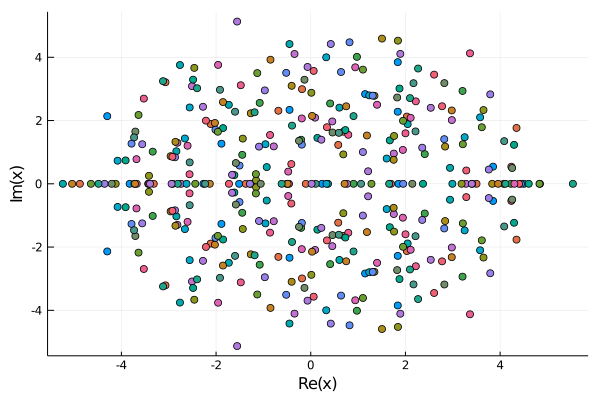

In [14]:
scatter(E,legend=false)

In [20]:
k=50
n=20
E=Array{Float64}(undef,n,k)
# Symmetric random uniform distribution
for i=1:k
    A=Symmetric(randn(n,n))
    E[:,i]=eigvals(A)
end

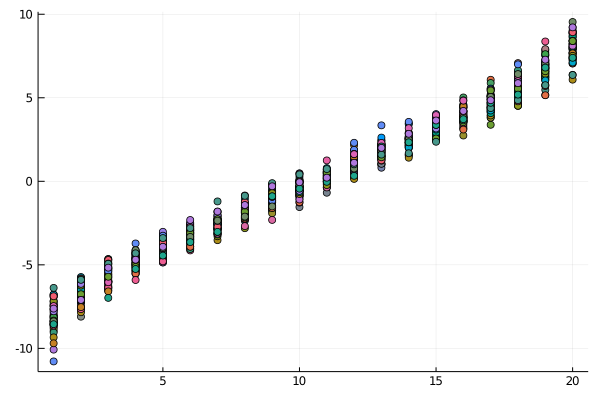

In [21]:
scatter(E,legend=false)